# Guiding questions

What fields of study are international students in the U.S. entering?

In [27]:
from collections import defaultdict
from fuzzywuzzy import fuzz, process
from bs4 import BeautifulSoup, Tag
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import requests

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
fields = [
    'agriculture',
    'business and management',
    'communications and journalism',
    'education',
    'engineering',
    'fine and applied arts',
    'health professions',
    'humanities',
    'intensive english',
    'legal studies and law enforcement',
    'math and computer science',
    'physical and life sciences',
    'social sciences',
]
years = [y for y in range(1999, 2018)]

In [3]:
def scrapeSite(year):
    yr = year
    if year == 2015:
        yr -= 1
    r = requests.get(
        'https://www.iie.org/Research-and-Insights/Open-Doors/Data/International-Students' + 
        f'/Fields-of-Study/Fields-of-Study/{yr}-{str(yr+2)[-2 if yr > 1999 else 0:]}'
    )
    table = BeautifulSoup(r.content).table
    table.tr.decompose()
    df = pd.read_html(str(table))[0]
    columns = df.iloc[0].str.lower()
    columns[2 if year == 2015 else 1] = 'population' # rename column we want to Population
    df.columns = columns
    df = df.reindex(df.index.drop(0))
    df = df.dropna(subset=['field of study']) # drop columns with NaN fields
    df['field of study'] = df['field of study'].str.lower().str.replace(', total', '')
    return df

# Data from 2016 - 2018 weren't scrapeable, but they
# were downloadable.
xls = pd.ExcelFile('../data/International-Students-Fields-of-Study.xlsx')
# Table 1: International Students by Field of Study & Academic Level, 2016/17 & 2017/18
recentTable = pd.read_excel(xls, '1', usecols=[0, 1, 2, 3], header=6, names=['field of study', '2016/2017', '2017/2018', '% change'])
recentTable = recentTable.dropna(subset=['field of study'])
recentTable['field of study'] = recentTable['field of study'].str.lower().str.replace(', total', '')

def scrapeRecents(year):
    return recentTable.rename(columns={ f'{year}/{year+1}': 'population' })

def getYearTable(year):
    if year < 1999 or year > 2017:
        print('Year must be between 1999 - 2017.')
        return
    return scrapeSite(year) if year <= 2015 else scrapeRecents(year)

In [4]:
tables = {year: getYearTable(year) for year in years}

In [5]:
fieldPopulations = {f: [] for f in fields}
holeyFields = set()

for field in fields:
    for year in years:
        table = tables[year]
        tableFields = list(table['field of study'].unique())
        match, score = process.extractOne(field, tableFields, scorer=fuzz.partial_ratio)
        if score < 84: # experimentally derived/hard-coded bad score
            fieldPopulations[field].append(None)
            holeyFields.add(field)
        else:
            fieldPopulations[field].append(
                int(table[table['field of study'] == match].iloc[0]['population'])
            )

In [10]:
# sum all field populations for calculating proportions
yearTotals = []
fields = [f for f in fields if f not in holeyFields]
for i in range(len(years)):
    yearTotals.append(
        sum([ fieldPopulations[f][i] or 0 for f in fields ])
    )
    
def maxWithNone(ary):
    return max([a or 0 for a in ary])

# calculate proportions
fields = sorted(fields, key=lambda f: maxWithNone(fieldPopulations[f]), reverse=True)
proportions = {}
for f in fields:
    populations = fieldPopulations[f]
    proportions[f] = [populations[i] / yearTotals[i] for i in range(len(years))]

== From top to bottom ==
agriculture
humanities
education
health professions
intensive english
fine and applied arts
physical and life sciences
social sciences
math and computer science
business and management
engineering


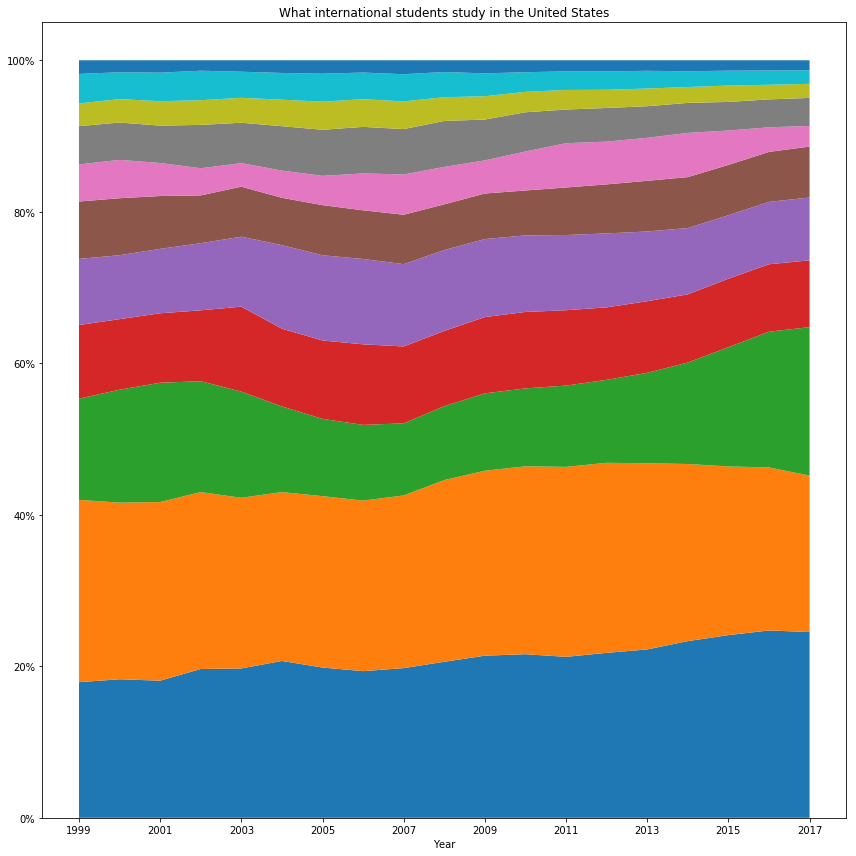

In [30]:
stacks = list(proportions.values())
labels = list(proportions.keys())

plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
plt.stackplot(years, stacks, labels=labels, linewidth=1)

# Make y values percentages
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Make legend on right side of graph
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Year')
plt.xticks(np.arange(min(years), max(years) + 1, 2))
plt.title('What international students study in the United States')

plt.tight_layout()
plt.savefig('stacked_fields.pdf', transparent=True)
print('== From top to bottom ==')
for label in reversed(labels):
    print(label)

# Findings